In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
    
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from keras_preprocessing import image
import keras
from sklearn.model_selection import train_test_split

import os
print(os.listdir("../Python Lab/input"))

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3 # RGB color


['sampleSubmission.csv', 'test1', 'train']


In [3]:
filenames = os.listdir("../Python Lab/input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('C1')
    else:
        categories.append('C0')

df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})
from sklearn.utils import shuffle
df = shuffle(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 5920 to 14135
Data columns (total 2 columns):
filename    25000 non-null object
category    25000 non-null object
dtypes: object(2)
memory usage: 585.9+ KB


In [5]:
df.tail()

,filename,category
24701,dog.973.jpg,C1
14097,dog.11434.jpg,C1
8161,cat.6093.jpg,C0
10393,cat.8101.jpg,C0
14135,dog.11469.jpg,C1


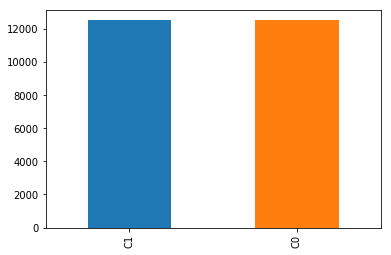

In [6]:
df['category'].value_counts().plot.bar()

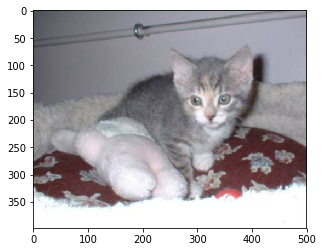

In [7]:
# see sample image
sample = random.choice(filenames)
image = load_img("../Python Lab/input/train/"+sample)
plt.imshow(image)

In [8]:
# Build model
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [9]:
# Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
#Early Stop
#To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
# Import EarlyStopping - method to stop training when a monitored quantity has stopped improving.
#Define a callback.Set monitor as val_acc, patience as 5 and mode as max so that 
#if val_acc does not improve over 5 epochs, terminate the training process.
earlystop = EarlyStopping(patience=10)

In [11]:
# Learning Rate Reduction
# We will reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [12]:
callbacks = [earlystop, learning_rate_reduction]

In [13]:
# Prepare Test and Train Data
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
image_width = 50
image_height = 50
image_size = (image_width, image_height)
image_channel = 3 # RGB color


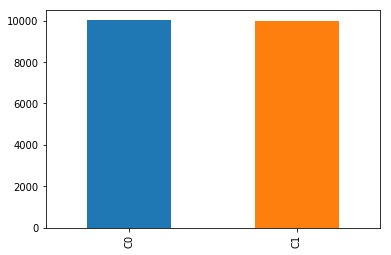

In [14]:
train_df['category'].value_counts().plot.bar()

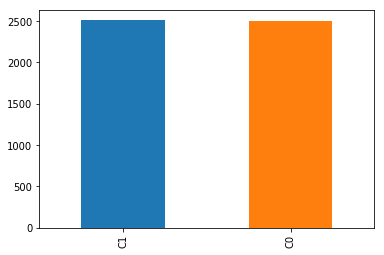

In [15]:
validate_df['category'].value_counts().plot.bar()

In [16]:
print(train_df.shape,validate_df.shape)

(20000, 2) (5000, 2)


In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [18]:
train_df.shape

(20000, 2)

In [28]:
from keras_preprocessing.image import ImageDataGenerator


In [30]:
#Fitting the CNN to the images
#Improve the dataset using the ImageDataGenerator method which generate batches of tensor image data with 
#real-time data augmentation.
#rescale: rescaling factor. If None or 0, no rescaling is applied, otherwise the data is multiplied by the value provided.
#shear_range: Shear Intensity
#zoom_range: Range for random zoom.
#horizontal_flip: Randomly flip inputs horizontally if true.
#Define the training and test datasets using the flow_from_directory which takes the path to a directory, 
#and generates batches of augmented/normalized data.
#directory: path to the target directory. It should contain one subdirectory per class.
#target_size: The dimensions to which all images found will be resized.
#class_mode: one of "categorical", "binary", "sparse", "input" or None. Determines the type of label arrays that are returned
#batch_size: size of the batches of data
train_data_dir =  'E:/Insofe/Python Lab/input/train'
# Training Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_data_dir,
    x_col = 'filename',
    y_col = 'category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size)


Found 20000 images belonging to 2 classes.


In [31]:
# Validation generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "../Python Lab/input/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=3
)

Found 5000 images belonging to 2 classes.


In [35]:
#Fit the Model
#Invoke the fit_generator to fits the model on data generated batch-by-batch by a Python generator.
#steps_per_epoch’ holds the number of training images, i.e 8000
#A single epoch is a single step in training a neural network,set it at 25.
#callbacks: List of callbacks to apply during training.
#validation_data: test data
#validation_steps: Total number of steps (batches of samples) to yield from validation_data generator before stopping 
#at the end of every epoch. It should typically be equal to the number of samples of your validation dataset divided by the
#batch size.
FAST_RUN = False
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
    
)

Epoch 1/50
1332/1333 [============================>.] - ETA: 0s - loss: 0.5226 - acc: 0.7411

TypeError: update() got an unexpected keyword argument 'force'

NameError: name 'history' is not defined

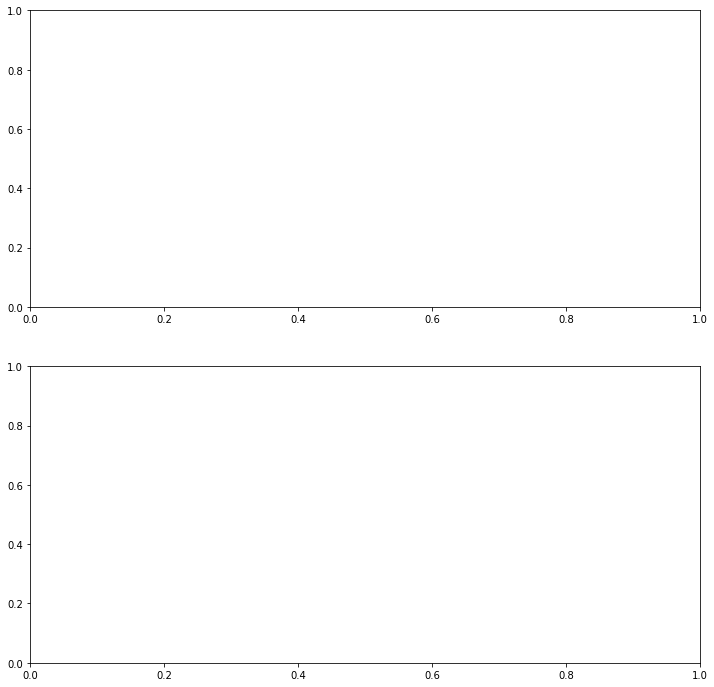

In [100]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [101]:
# Save Model
model.save_weights("model.h5")

In [102]:
# Prepare Testing Data
test_filenames = os.listdir("../Python Lab/input/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]


In [103]:
# Create Testing Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../Python Lab/input/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 images.


In [104]:
# Predict
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_7/convolution}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_7/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_7/kernel/read)]]
	 [[{{node dense_6/Sigmoid/_341}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_303_dense_6/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
# As predicted of binary classification result return probability that image likely to be a dog. So we will have threshold 0.5 which mean if predicted value more than 50% 
#it is a cqt and under 50% will be a dog.
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 0,1)

In [ ]:
# Virtaulize Result
test_df['category'].value_counts().plot.bar()

In [ ]:
# See predicted result with images
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img("../Python Lab/input/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()

In [46]:
# Submission
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_Catdog.csv', index=False)

In [22]:
!pip install keras==2.2.4

  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Found existing installation: Keras 2.1.3
    Uninstalling Keras-2.1.3:
      Successfully uninstalled Keras-2.1.3
